# Beaver River diabase and anorthosite xenoliths cooling model

We are interested in modeling heat transfer during the emplacement and subsequent cooling of the Beaver River diabase and the anorthosite xenoliths inclusions therein. We are particularly interested in understanding the timescale for cooling different sizes of the anorthosite xenoltihs. 

First we use some simplifications and assumption of the case. 
1. We assume the AX first separated out of the parent magma because of buoyancy under high presssure, and stayed at a cooler temperature than the BRD which later came in and entrained the anorthosites. To test the extreme conditions, we assume the initial temperature of the anorthosite to be 50 degree C (that the anorthosite was already emplaced to hypabyssal depth by the time of diabase emplacement). 
2. We simplify the geometry of the anorthosite inclusions into spheres with various sizes. We simply the geometry of diabase sill to be an infinite long sheet with known thickness. 
3. We assume the diabase sill was able to maintain a uniform temperature (i.e. the cooling effect caused by coolor anorthosite didn't cause significant temperature drop of the BRD). We currently neglect the latent heat from crystallization processes. 
4. We assume the pressure is constant.
5. We test whether the emplacemnt duration (~1091-1095 Ma) is sufficient for the BRD to heat up even for the largest anorthosite body observed. 

The problem of heat transfer of an idealized dike or sill body was dealt with nicely in an article published by Paul T. Delaney of the US Geological Survey, and Fairchild et al (2016) has had successful python implementation on this model:
- Delaney, P.T. 1987. Heat transfer during emplacement and cooling of mafic dykes In Mafic dyke swarms. Edited by H.C. Halls and W.F. Fahrig. Geological Association of Canada, Special Paper 34, pp. 31-46.
- Fairchild, L. M., Swanson-Hysell, N. L., & Tikoo, S. M. (2016). A matter of minutes: Breccia dike paleomagnetism provides evidence for rapid crater modification. Geology, 44, 723-726. https://doi.org/10.1130/G37927.1

The problem of heat transfer of a solid sphere within an environment with uniform temperature was dealt with nciely in an article by Unsworth, J. and Duarte, F. J.
- Unsworth, J., & Duarte, F. J. (1979). Heat diffusion in a solid sphere and Fourier theory: an elementary practical example. American Journal of Physics, 47(11), 981-983. https://doi.org/10.1119/1.11601. 

References for thermal properties of diabase and anorthosite:
- Drury, M. J. (1987). Thermal diffusivity of some crystalline rocks. Geothermics, 16(2), 105-115. https://doi.org/10.1016/0375-6505(87)90059-9
- Robertson, E. C. (1988). Thermal properties of rocks (No. 88-441). US Geological Survey. https://pubs.usgs.gov/of/1988/0441/report.pdf

## An analytical solution to transient heat conduction for Beaver River diabase

Delaney (1987) formulates the problem by idealizing a dike as a tabular plane of infinite extent. Coordinates are based on the position of the dike wall with the $X$-direction being the direction orthogonal to the wall such that negative $X$ values are within the dike and positive $X$ values are in the host rock. The dike has a thickness $T$ and an initial temperature $\Theta_{mi}$ (subscript stands for magma initial). The host rock has an initial temperature $\Theta_{hi}$ and a thermal diffusivity $\kappa_h$.
> Conservation of energy for a motionless material undergoing one-dimensional heat transfer with no chemical reactions is (Carslaw and Jaeger, 1959, Ch. 1; Bird et al., 1960, Ch.10):
\begin{equation}
\rho C\frac{\partial\Theta}{\partial t} = \frac{\partial}{\partial X}k\frac{\partial\Theta}{\partial X}
\end{equation}
This equation states that the heat conducted into a unit volume minus the heat conducted out is equal to the accumulation of heat within the volume. The right-hand side of equation 1 is the gradient in heat flux, which is given by Fourier's Law, $Q = - k\partial\Theta/\partial X$ where $k$ is thermal conductivity; the left-hand side is the rate of accumulation of heat, where pC is heat capacity per unit volume. If k is constant, then:
\begin{equation}
\frac{\partial\Theta}{\partial t} = \kappa\frac{\partial^2\Theta}{\partial X^2}
\end{equation}
Thermal diffusivity, $\kappa = k/(pC)$, measures the ability of a material to conduct heat relative to its ability to accumulate heat.

> Generality and simplicity are gained by introducing non-dimensional temperature $\theta$, distance $x$, and time $\tau$:

> \begin{equation}
\theta = (\Theta-\Theta_{hi})/(\Theta_{mi}-\Theta_{hi})
\end{equation}

> \begin{equation}
x = X/(T/2)
\end{equation}

> \begin{equation}
\tau = t*\kappa_h/(T/2)^2
\end{equation}

Following this introduction, Delaney builds up to presenting the first and simplest whole-time solution. This solution neglects themal property contrasts between the host rock and dike (i.e. $\kappa_m/\kappa_h=1$). These thermal property contrasts can affect the maximum temperatures reached in the host rock and early cooling rates, but the influence is rather small. This whole-time solution is:

> \begin{equation}
\theta = \frac{1}{2}[erf\big(\frac{2+x}{\sqrt{4\tau}}\big)-erf\big(\frac{x}{\sqrt{4\tau}}\big)]
\end{equation}

Delaney also presents numerical solutions that incorporate the effects of the heat of crystallization, magma flow and the temperature dependance of thermal conductivity and diffusivity. In the application that we are exploring here, the cooling of a breccia dike emplaced within an impact crater neither the heat of crystallization nor magma flow apply and therefore the analytical solution using transient heat conduction theory will work well for our analysis. 



## An analytical solution to heat diffusion for anorthosite xenoliths


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy import special
from scipy import optimize
from scipy.constants import Julian_year
%config InlineBackend.figure_formats = {'svg',}
%matplotlib inline

## Defining sill cooling model, anorthosite thermal diffusion model, and orthoregression calculation functions

In [2]:
def dike_cooling(t,distance_from_contact,temp_dike,temp_host,dike_width,kn):
    x_nd = distance_from_contact/(dike_width/2)
    tau_nd = t * kn/((dike_width/2.0)**2)
    temp_nd =  0.5 * (special.erf((2+x_nd)/np.sqrt(4*tau_nd)) - special.erf(x_nd/np.sqrt(4*tau_nd)))
    temp = temp_nd*(temp_dike-temp_host) + temp_host
    return temp

# defining anorthosite cooling function, taking initial interior temperature, initial boundary temperature, radius of xenolith in meter, 
def anorthosite_cooling(time_step, radius, initial_temp, boundary_temp):
    AX_thermal_conductivity = 0.5 # unit is 10^-3 cal/cm sec K 
    AX_thermal_diffusivity = 0.95e-6; # unit is m^2/s, from Drury1987a, the number is 0.95 for plagioclase, 0.85 for orthoclase
    AX_density = 2.7 # unit is g/cm3
    K = AX_thermal_diffusivity  # unit is m2/s
    n = 101

    j = 1
    rightside = 0
    T0 = 0
    
    while j < n:
        rightside = rightside + pow(-1, j + 1 ) * np.exp(- K * j * j * np.pi * np.pi * time_step / (radius * radius))
        j = j + 1

    T0 = (initial_temp - boundary_temp) * 2 * (rightside) + boundary_temp

    return T0

# importing deming regression/orthogonal regression
def orthoreg(xvals, yvals):
    i = 0
    xsum = 0
    ysum = 0
    n = len(xvals)
    for i in range(n):
        xsum = xsum + xvals[i]
        ysum = ysum + yvals[i]
    N = n*1.0
    xm = xsum/N
    ym = ysum/N
    
    sxx = 0
    sxy = 0
    syy = 0
    for i in range (n):
        sxx = sxx + (xvals[i]-xm) * (xvals[i] - xm)
        sxy = sxy + (xvals[i]-xm) * (yvals[i] - ym)
        syy = syy + (yvals[i]-ym) * (yvals[i] - ym)
    sxx = sxx/(N-1)
    sxy = sxy/(N-1)
    syy = syy/(N-1)
    
    m = syy - sxx + ((syy - sxx) * (syy - sxx) + 4 * sxy * sxy)**0.5
    m = m / (2 * sxy)
    b = ym - m * xm
    outlist = (m, b)
    return outlist
        

## Linear regression on diabase specific heat capacity change with respect to temperature

Here we plot the diabase specific heat capacity change against temperature. 
It turns out there is almost linear relationship between temperature of diabase and the specific heat of the lithology. 

Unfortunately, there is not enough data to investigate plagioclase specific heat capacity changes with respect to temperature. 

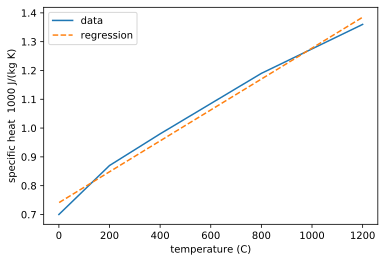

In [3]:
Diabase_specific_temp_list = [0, 200, 400, 800, 1200]
Diabase_specific_heat_list = [0.7, 0.87, 0.98, 1.19, 1.36] #(1000 J/(kg K)

# lets find the orthogonal regression for this curve
m, b = orthoreg(Diabase_specific_temp_list, Diabase_specific_heat_list)

plt.plot(Diabase_specific_temp_list, Diabase_specific_heat_list, label='data')
plt.plot([1, 1200], [m+b, 1200 * m+b], '--', label='regression')

plt.legend()
plt.xlabel('temperature (C)')
plt.ylabel('specific heat  1000 J/(kg K)')
# plt.savefig('Diabase_heat_capacity_curve.pdf')
plt.show()

## Determine the thickness of Beaver River diabase sill

Notes on the reason we choose 300 meters for the thickness of the diabase sill:

- On Illgen city map cross section, the calculated thickness is roughly 180 meter;
- On Silver Bay map cross section Miller has about 100m thickness plotted;
- On Tofte map BRD thickness is about 800 feet, which is about 250 meter;
- On Silver Bay map the calculated thickness is about 260 meter


for the moment, we don't have a perfect idea of the size of the Carlton, and field mapping showed it's not as big as reported in previous literature, at least the mapped exposed part. 

Therefore, we are using 100 meter for the size of the Carlton peak xenolith and pretend we were sampling its middel
*need to improve but using 300 meter as a maximum thickness seems reasonable

In [4]:
# input parameters for dike model
# temp_dike = 1100 #in Celcius, the inital temperature of diabase sill/dike
# temp_host = 50.0 #in Celcius, the hypabyssal temperature
# temp_anorthosite = 200 # in Celcius 

# dike_width = 200 #in meters
# distance_from_contact = -dike_width/2 # here we don't want temperature at a distance away from contact, but want the temperature at center of dike, which should be a negative half dike thickness
diabase_density = 2800 # 2.8 kg/m3
diabase_thermal_conductivity = 2.143  # W m-1 K-1
kn = diabase_thermal_conductivity/diabase_density/1360
print(kn)
# kn = 7.35e-7 #thermal diffusivity (m^2/s)

5.627626050420168e-07


## Combining sill cooling model and anorthosite thermal diffusion model into one

In [9]:
def anorthosite_diabase_cooling(diabase_initial_temp,diabase_k,sill_thickness,host_temp,
                                anorthosite_initial_temp, anorthosite_radius,time_steps, 
                                savefig = False, figname = None):

    temp_anorthosite = list()
    temp_diabase = list()
    k_diabase = list()
    
    distance_from_contact = -sill_thickness/2

    # make i as the time step
    for i in time_steps:
        diabase_temp = dike_cooling(i ,distance_from_contact, diabase_initial_temp, host_temp, sill_thickness, diabase_k)
        diabase_k = diabase_thermal_conductivity/diabase_density/(m*diabase_temp+b)/1000
        anorthosite_temp = anorthosite_cooling(i, anorthosite_radius, anorthosite_initial_temp, diabase_temp)
        temp_diabase.append(diabase_temp)
        temp_anorthosite.append(anorthosite_temp)
        k_diabase.append(diabase_k)
    
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_xticks([86400, Julian_year, Julian_year*100, Julian_year*1000, Julian_year*1e5, Julian_year*1e7])
    ax.set_xticklabels(['1 day', '1 year', '100 yr', '1 Kyr', '100 Kyr', '10 Myr'])
    ax.set_yticks([0, 50, 200, 400, 580, 800, 1000, 1200])
#     ax.plot([4e10, 10e12], [580, 580], '--', color = 'C0') # magnetite curie temp
#     ax.plot([Julian_year*1100, Julian_year*1100], [0, 580], '--', color = 'C0') # magnetite curie temp
    
#     ax.plot([5e10, 10e12], [500, 500], '--', color = 'orange') # 500 C line
#     ax.plot([Julian_year*1900, Julian_year*1900], [0, 500], '--', color = 'orange') # 500 C line

    ax.plot([Julian_year*100, Julian_year*100], [0, diabase_initial_temp], '--', color = 'grey')
    
    ax.plot(time_steps, temp_diabase, color = 'blue', label = 'diabase', linewidth = 3.5)
    ax.plot(time_steps, temp_anorthosite, color = 'red', label = 'anorthosite', linewidth = 2)
#     plt.plot(time_steps, k_diabase, color = 'green', label = 'diabase k', linewidth = 2)
    
    ax.set_title('anorthosite diameter: ' + str(anorthosite_radius * 2) + ' m')
#     ax.text(Julian_year*0.2e5, 610, '580$^\circ$C', color = 'C0')
#     ax.text(Julian_year*0.2e5, 420, '500$^\circ$C', color = 'orange')
    ax.set_xlim((min(time_steps)-1000, max(time_steps)+1000))
    ax.set_ylim((0, 1250))
    ax.set_xlabel('time')
    ax.set_ylabel('temperature (°C)')
    ax.legend()
#     if savefig == True:
#         plt.savefig('../Figure/Cooling_plots/'+figname + '.pdf')
        
#     plt.show()
    
    return time_steps, temp_diabase, temp_anorthosite, fig, ax #temp_anorthosite

## 1 meter wide anorthosite body

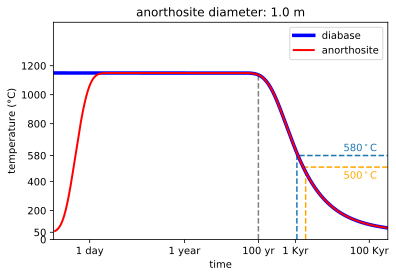

In [7]:
sill_thickness = 300 #in meters
anorthosite_initial_temp = 50 # initialize a anorthosite temp step variable
anorthosite_radius = 0.5
diabase_initial_temp = 1150 # using 1150 degree C as the bounds for a olivine tholeiitic diabase magma melt
host_temp = 50
time_steps = np.logspace(4, 13, num = 10000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case1_t, case1_diabase, case1_anorthosite, fig1m, ax1m = anorthosite_diabase_cooling(diabase_initial_temp,diabase_k,sill_thickness,host_temp,
                                                      anorthosite_initial_temp,anorthosite_radius,time_steps)
# plt.savefig('../Figure/Cooling_plots/1 meter anorthosite.pdf')

## 10 meter wide anorthosite body

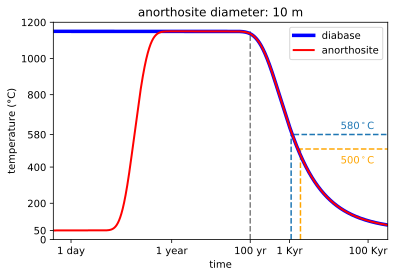

In [7]:
sill_thickness = 300 #in meters
anorthosite_initial_temp = 50 # initialize a anorthosite temp step variable
anorthosite_radius = 5
diabase_temp = 1150
host_temp = 50
time_steps = np.logspace(4.5, 13, num = 10000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case2_t, case2_diabase, case2_anorthosite, fig10m, ax10m = anorthosite_diabase_cooling(diabase_temp,diabase_k,sill_thickness,host_temp,
                                                                        anorthosite_initial_temp,anorthosite_radius,time_steps)
plt.savefig('../Figure/Cooling_plots/10 meter anorthosite.pdf')

## AX16 specific thermal model (xenolith with both pmag and geochron study)

This xenolith in Silver bay area is dated by CA-ID-TIMS at Boise State Univeristy. Paleomagnetic study was conducted at UC Berkeley Paleomagnetism lab. Fieldnote during 2019 field season measured its size being 27.5 m across the exposed part on road cut, which should be considered a minimal size. Here in model we assume the anorthosite as a sphere with diameter of 27.5 meters. 

**The BRD unit at this location has an average dip direction of 121.2, dip of 11.2. The apparent thickness along dip direction is 1662.7 meters. Using trigonometry the actual thickness of diabase should be 1662.7$\times$sin(11.2$^\circ$) = 323 meters**

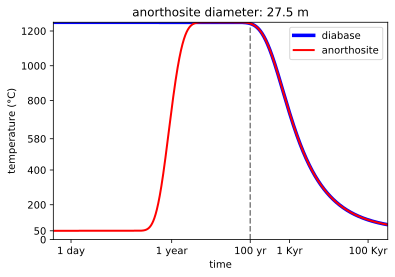

In [10]:
sill_thickness = 323 #in meters
anorthosite_initial_temp = 50 # initialize a anorthosite temp step variable
anorthosite_radius = 27.5/2
diabase_temp = 1250
host_temp = 50
time_steps = np.logspace(4.5, 13, num = 10000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case3_t, case3_diabase, case3_anorthosite, fig16_50, ax16_50 = anorthosite_diabase_cooling(diabase_temp,diabase_k,sill_thickness,host_temp,
                                                                        anorthosite_initial_temp,anorthosite_radius,time_steps)
# plt.savefig('../Figure/Cooling_plots/AX16_thermal_model_50C.pdf')

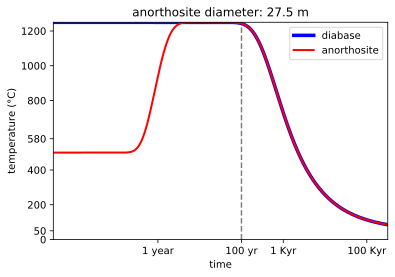

In [11]:
sill_thickness = 323 #in meters
anorthosite_initial_temp = 500 # initialize a anorthosite temp step variable
anorthosite_radius = 27.5/2
diabase_temp = 1250
host_temp = 50
time_steps = np.logspace(5, 13, num = 10000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case4_t, case4_diabase, case4_anorthosite, fig16_500, ax16_500 = anorthosite_diabase_cooling(diabase_temp,diabase_k,sill_thickness,host_temp,
                                                                        anorthosite_initial_temp,anorthosite_radius,time_steps)

In [36]:
ax16_50.plot(case4_t, case4_anorthosite, color = 'red', linewidth=2, label = '500$^\circ$C')
ax16_50.text(86400, 540, '500$^\circ$C', color = 'red')
ax16_50.text(86400, 80, '50$^\circ$C', color = 'red')
fig16_50.savefig('../Figure/Cooling_plots/AX16_thermal_model.pdf')

## 100 meter wide anorthosite body

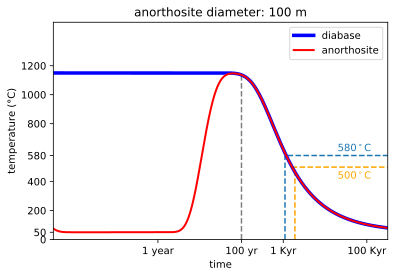

In [47]:
sill_thickness = 300 #in meters
anorthosite_initial_temp = 50 # initialize a anorthosite temp step variable
anorthosite_radius = 50
diabase_temp = 1150
host_temp = 50
time_steps = np.logspace(5, 13, num = 10000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case5_t, case5_diabase, case5_anorthosite, fig100m, ax100m = anorthosite_diabase_cooling(diabase_temp,diabase_k,sill_thickness,host_temp,
                                                                        anorthosite_initial_temp,anorthosite_radius,time_steps)
# plt.savefig('../Figure/Cooling_plots/100 meter anorthosite.pdf')

## 800m Carlton Peak in 1000 meter wide diabase sill

[Text(0, 0, '1 year'),
 Text(0, 0, '100 yr'),
 Text(0, 0, '1 Kyr'),
 Text(0, 0, '12 kyr'),
 Text(0, 0, '100 Kyr')]

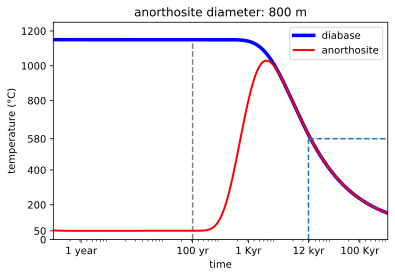

In [32]:
sill_thickness = 1000 #in meters
anorthosite_initial_temp = 50 # initialize a anorthosite temp step variable
anorthosite_radius = 400
diabase_temp = 1150
host_temp = 50
time_steps = np.logspace(7, 13, num = 1000)
# time_steps = np.arange(10e6, 10e9, 5*10e6)


diabase_k = kn

case5_t, case5_diabase, case5_anorthosite, fig1000m, ax1000m = anorthosite_diabase_cooling(diabase_temp,diabase_k,sill_thickness,host_temp,
                                                                        anorthosite_initial_temp,anorthosite_radius,time_steps)
ax1000m.plot([Julian_year*12000, 10e12], [580, 580], '--', color = 'C0') # magnetite curie temp
ax1000m.plot([Julian_year*12000, Julian_year*12000], [0, 580], '--', color = 'C0') # magnetite curie temp
ax1000m.set_xticks([Julian_year, Julian_year*100, Julian_year*1000, Julian_year*12000, Julian_year*1e5])
ax1000m.set_xticklabels(['1 year', '100 yr', '1 Kyr', '12 kyr', '100 Kyr'])
# plt.savefig('../Figure/Cooling_plots/700 meter diabase.pdf')

# Conclusion

According to the models, all observed sizes of anorthosirte xenoliths in the Beaver River diabase are likely to have been fully remagnetized during the emplacement and cooling of Beaver River diabase. 

# Cooling rate correction for anorthosite paleointensity results

Differences between lab cooling rates and natural cooling rates may have a strong effect on the estimate of the paleointensity. 
Cooling rate dependence on SD grains has been extensively studied. Halgedahl (1980) used both analytical and numerical approaches based on Neel theory. She derived that:

$$n_{B}/n_{B,L} = \sqrt{T_{B,L}/T_{B}}\sqrt{\left [ \ln(\dot{T}_{B,L}/\dot{T}_{B}) + \ln({z}_{B,L}/{z}_{B})\right ]/\xi_{B,L} + 1  } \;(H/H_{L})$$

Where: 
- $n_{B}/n_{B,L}$ is the ration between 'natural' and 'laboratory' TRM 
- $T_{B,L}$ and $T_{B}$ are the lab and natural blocking temperatures
- $\dot{T}_{B,L}$ and $\dot{T}_{B}$ are the lab and natural cooling rates
- ${z}_{B,L}$ and ${z}_{B}$ are related to the lab and natural energy barrier at temperature T
- $\xi_{B,L}$ euqals to $(E/kT)_{B,L}$
- $H$ and $H_{L}$ are the inducing field in nature and in lab

Halgedal et al., (1980) argued that the term ${z}_{B,L}/{z}_{B}$ is near 1; therefore the ratio between lab and natural TRM should be solely a function of $\ln(\dot{T}_{B,L}/\dot{T}_{B})$ near Curie temperature. In addition, this relatioship suggests that the ratio is nearly linear with cooling rate ratio. 

However, to extend the equation to lower ublocking temperature, we have to take into account the term $\sqrt{T_{B,L}/T_{B}}$, in that the difference between lab unblocking temperature will become more and more significant at lower temperatures. To better determine the value of $\sqrt{T_{B,L}/T_{B}}$, we refer to the fundamental function delineating the relationship between relaxation time and unblocking temperature, $$\tau = \frac{1}{C}exp(\frac{vh_{c}j_{s}}{2kT})$$, where $\tau$ is the relaxation time, $C$ is the frequency factor, $v$ is the volume of grains, $h_{c}$ is the microscopic coercive force, $j_{s}$ is the saturation magnetization at temperature T, $k$ is the Boltzman constant. Using this equation, we can derive the ratio between equivalent unblocking temperature and lab unblocking temperature when lab cooling rate and ancient cooling rate are given (Pullaiah 1975).

However, the complication here is that the saturation magnetization is also a function of temperature. Therefore, we need to refer to another equation, the power law function which described the ratio between the saturation magnetizations as a function of temperature: $$\frac{M_{s}[T]}{M_{s}[T_{0}]}=\left | \frac{T_{c}-T}{T_c-T_0} \right |^{\gamma }$$

After incorporating all above equations into one, we now have an equation that is solely a functin of cooling time, in that the ration between lab unblocking temperature and natural unblocking temperature can be expressed by the lab and natural relaxation time: $$\left ( \frac{U }{G}\right )^{\frac{1}{2\gamma }}=\frac{T_c-T_1}{T_c-\frac{T_1}{U}}$$ 
where U is the ratio between lab and natural unblocking temperature, $\frac{T_1}{T_2}$, G is $\frac{ln(\tau_2\cdot C)}{ln(\tau_1\cdot C)}$, $\gamma$ is the power law variation number, and $T_c$ is Curie temperature of amgnetite in this case.

Therefore, the euqation from Halgedahl becomes: $$n_{B}/n_{B,L} = \sqrt{U}\sqrt{\left [\ln(\dot{T}_{B,L}/\dot{T}_{B}) + 0)\right ]/25 + 1} \cdot 1 $$


It is important to note that the theory used in Halgedal et al., (1980) is constrained to an assemblage of identical, single-domain grains with given axial ratio. 

In [12]:
def PINT_cooling_rate(cooling_interval, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 580+273.15):
    Tc = 580 +273.15
    natural_cooling_rate = cooling_interval/natural_cooling_time
    lab_cooling_rate = cooling_interval/lab_cooling_time
    print('natural_cooling_rate: ', cooling_interval/5e10, 'lab_cooling_rate: ', cooling_interval/1200)
#     anc_blocking_temp = Neel_theory(lab_blocking_temp, lab_cooling_time, natural_cooling_time)
#     anc_blocking_temp = anc_blocking_temp/((Tc-lab_blocking_temp)/(Tc-anc_blocking_temp))**0.76
    C = 1e10
    G = np.log(natural_cooling_time*C)/np.log(lab_cooling_time*C)
    TBL_TB = []
    for i in G:
        def get_root(u):
            return (u/i)**0.76*(Tc-lab_blocking_temp/u)-(Tc-lab_blocking_temp)
        TBL_TB.append(optimize.root(get_root, 1).x[0])
#     print(TBL_TB)
    
    nB_nBL = []
    for j in range(len(TBL_TB)):
        nB_nBL.append(np.sqrt(TBL_TB[j])*np.sqrt((1+np.log(lab_cooling_rate/natural_cooling_rate[j])/25)))
#     print(nB_nBL)
    return nB_nBL

def power_law(T, Tc = 580+ 273.15):
    MsT_MsT0 = (abs((Tc-T))/(Tc))**0.38
    return MsT_MsT0

def Neel_theory(T1, tao1 = 100, tao2 = 100):
    C = 1e10
    T2 = T1*np.log(C*tao1)/np.log(C*tao2)
    
    return T2

natural_cooling_rate:  1.6e-09 lab_cooling_rate:  0.06666666666666667
natural_cooling_rate:  1.6e-09 lab_cooling_rate:  0.06666666666666667
natural_cooling_rate:  1.6e-09 lab_cooling_rate:  0.06666666666666667
natural_cooling_rate:  1.6e-09 lab_cooling_rate:  0.06666666666666667
natural_cooling_rate:  1.6e-09 lab_cooling_rate:  0.06666666666666667


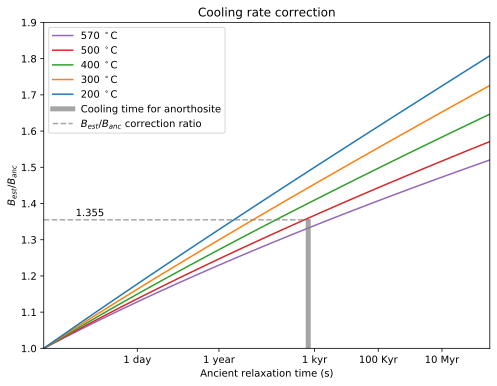

In [13]:
natural_cooling_time = np.logspace(2, 16)
nB_nBL = PINT_cooling_rate(80, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 570+273.15)
nB_nBL_1 = PINT_cooling_rate(80, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 500+273.15)
nB_nBL_2 = PINT_cooling_rate(80, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 400+273.15)
nB_nBL_3 = PINT_cooling_rate(80, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 300+273.15)
nB_nBL_4 = PINT_cooling_rate(80, natural_cooling_time, lab_cooling_time=100, lab_blocking_temp = 200+273.15)

plt.figure(figsize=(8,6))
plt.plot(natural_cooling_time, nB_nBL, color = 'C4', label = '570 $^\circ$C')
plt.plot(natural_cooling_time, nB_nBL_1, color = 'C3', label = '500 $^\circ$C')
plt.plot(natural_cooling_time, nB_nBL_2, color = 'C2', label = '400 $^\circ$C')
plt.plot(natural_cooling_time, nB_nBL_3, color = 'C1', label = '300 $^\circ$C')
plt.plot(natural_cooling_time, nB_nBL_4, color = 'C0', label = '200 $^\circ$C')

plt.plot([2e10, 2e10], [1., 1.35], color = 'grey', linewidth = 5, alpha = 0.7, label = 'Cooling time for anorthosite')
plt.plot([1e2, 2e10], [1.355, 1.355], '--', color = 'grey', alpha = 0.7, label = '$B_{est}$/$B_{anc}$ correction ratio')
plt.xscale('log')
plt.xticks([86400, 3.154e+7, 3.154e+10, 3.154e+12, 3.154e+14], ('1 day', '1 year', '1 kyr', '100 Kyr', '10 Myr'))
plt.text(1e3, 1.365, '$\mathit{1.355}$', style = 'italic', color = 'black')
plt.xlim(1e2, 1e16)
plt.ylim(1, 1.9)
plt.xlabel('Ancient relaxation time (s)')
plt.ylabel('$B_{est}$/$B_{anc}$')

plt.title('Cooling rate correction')
plt.legend()
# plt.savefig('../Figure/Cooling_plots/Cooling_rate_correction.pdf')
plt.show()

The figure above shows a variety of populations of SD grains: Those with lab unblocking temperature (100s relaxation time) of 200$^\circ$C, 300$^\circ$C, 400$^\circ$C, 500$^\circ$C, 570$^\circ$C, respectively. accoridng to the cooling model for anorthosite xenoliths in the above chapter, the over estimate ratio at unblocking temperature 500$^\circ$C is about 1.35. Therefore, we should correct our estimated ancient field strength by a factor of 0.74. 

A broader implication of this cooling rate correction theory is that because of the suppression of unblocking/blocking temperature due to slow cooling rate, we are not able to recover any paleomagnetic record from the time when the anorthosites were above a few tens of degrees below the Curie temperature. 